# Аналитика в Яндекс.Афише

## Содержание проекта:
1. <a href='#prj_description'>Описание проекта</a>
1. <a href='#data_description'>Описание данных</a>
1. <a href='#loading'>Загрузка и подготовка данных к анализу</a>
    - <a href='#visits'>Логи сервера с информацией о посещениях сайта `visits`</a>
    - <a href='#orders'>Информация о заказах `orders`</a>
    - <a href='#costs'>Информация о затратах на маркетинг `costs`</a>

1. <a href='#analysis'>Расчет метрик и построение отчетов</a>
    - <a href='#product'>Продукт</a>
        - <a href='#sticky_factor'>Сколько людей пользуются в день, неделю, месяц?</a>
        - <a href='#sessions_count'>Сколько сессий в день?</a>
        - <a href='#sessions_length'>Сколько длится одна сессия?</a>
        - <a href='#retention_rate'>Как часто люди возвращаются?</a>
    - <a href='#sales'>Продажи</a>
        - <a href = '#start_ordering'>Когда люди начинают покупать?</a>
        - <a href = '#purchases'>Сколько раз покупают за период?</a>
        - <a href = '#avg_check'>Какой средний чек?</a>
        - <a href = '#ltv'>Сколько денег приносят? (LTV)</a>
    - <a href='#marketing'>Маркетинг</a>
        - <a href = '#month_costs'>Сколько денег потратили? Всего / на каждый источник / по времени</a>
        - <a href = '#users_per_source'>Сколько стоило привлечение одного покупателя из каждого источника?</a>
        - <a href = '#roi'>На сколько окупились расходы? (ROI)</a>    
1. <a href = '#summary'>Выводы и рекомендации</a>

<a id='prj_description'></a>
# Описание проекта
На основании предоставленных данных необходимо сформировать рекомендации об использовании источников/платформ.

<a id='data_description'></a>
# Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):
- `Uid` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Start Ts` — дата и время начала сессии
- `End Ts` — дата и время окончания сессии
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь

Таблица `orders` (информация о заказах):
- `Uid` — уникальный id пользователя, который сделал заказ
- `Buy Ts` — дата и время заказа
- `Revenue` — выручка Яндекс.Афиши с этого заказа

Таблица `costs` (информация о затратах на маркетинг):
- `source_id` — идентификатор рекламного источника
- `dt` — дата
- `costs` — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

<a id='loading'></a>
# Загрузка и подготовка данных к анализу

<a id='visits'></a>
## Логи сервера с информацией о посещениях сайта `visits`

Прочитаем данные из файла, преобразовав столбцы с датами в формат `datetime`.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv', parse_dates=['End Ts', 'Start Ts'])

Приведем наименование столбцов к нижнему регистру. Изменим порядок столбцов.

In [3]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
columns = ['start_ts', 'end_ts', 'uid', 'source_id', 'device']
visits = visits[columns]

In [4]:
visits.head()

,start_ts,end_ts,uid,source_id,device
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch
3,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,9,desktop
4,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,3,desktop


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
start_ts     359400 non-null datetime64[ns]
end_ts       359400 non-null datetime64[ns]
uid          359400 non-null uint64
source_id    359400 non-null int64
device       359400 non-null object
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits.describe()

,uid,source_id
count,3.594000e+05,359400.000000
mean,9.202557e+18,3.750515
std,5.298433e+18,1.917116
min,1.186350e+13,1.000000
25%,4.613407e+18,3.000000
50%,9.227413e+18,4.000000
75%,1.372824e+19,5.000000
max,1.844668e+19,10.000000


В таблице отсутствуют пропущенные значения.

<a id='orders'></a>
## Информация о заказах

Прочитаем данные из файла, преобразовав столбец с датами в формат `datetime`.

In [7]:
orders = pd.read_csv('/datasets/orders_log.csv', parse_dates=['Buy Ts'])

Приведем наименование столбцов к нижнему регистру. Изменим порядок столбцов.

In [8]:
orders.columns = ['buy_ts', 'revenue', 'uid']
columns = ['buy_ts', 'uid', 'revenue']
orders = orders[columns]

In [9]:
orders.head()

,buy_ts,uid,revenue
0,2017-06-01 00:10:00,10329302124590727494,17.00
1,2017-06-01 00:25:00,11627257723692907447,0.55
2,2017-06-01 00:27:00,17903680561304213844,0.37
3,2017-06-01 00:29:00,16109239769442553005,0.55
4,2017-06-01 07:58:00,14200605875248379450,0.37


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
uid        50415 non-null uint64
revenue    50415 non-null float64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [11]:
orders.describe()

,uid,revenue
count,5.041500e+04,50415.000000
mean,9.098161e+18,4.999647
std,5.285742e+18,21.818359
min,3.135781e+14,0.000000
25%,4.533567e+18,1.220000
50%,9.102274e+18,2.500000
75%,1.368290e+19,4.890000
max,1.844617e+19,2633.280000


В таблице отсутствуют пропущенные значения. Среднее и медианное значение находятся довольно далеко друг от друга - присутствуют выбросы, заказы, сумма которых значительно отклонилась вправо от среднего значения.

<a id='costs'></a>
## Информация о затратах на маркетинг

Прочитаем данные из файла, преобразовав столбец с датами в формат `datetime`.

In [12]:
costs = pd.read_csv('/datasets/costs.csv', parse_dates=['dt'])

Изменим порядок столбцов.

In [13]:
columns = ['dt', 'source_id', 'costs']
costs = costs[columns]

In [14]:
costs.head()

,dt,source_id,costs
0,2017-06-01,1,75.20
1,2017-06-02,1,62.25
2,2017-06-03,1,36.53
3,2017-06-04,1,55.00
4,2017-06-05,1,57.08


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
dt           2542 non-null datetime64[ns]
source_id    2542 non-null int64
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [16]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


В таблице отсутствуют пропущенные значения.

<a id='cohorts'></a>
## Выделение когорт в таблицах

### Выделим когорты в таблице  `visits`

1. сгруппируем данные по uid и найдем самую раннюю дату визита `first_visit`
2. выделим год и месяц из даты первого визита

In [17]:
visits.head()

,start_ts,end_ts,uid,source_id,device
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch
3,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,9,desktop
4,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,3,desktop


In [18]:
# нейдем дату первого визита
first_visit = visits.groupby('uid')['start_ts'].min()

In [19]:
first_visit.name = 'first_visit'

In [20]:
first_visit = first_visit.reset_index()

In [21]:
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [22]:
# добавим дату первого визита в таблицу с визитами
visits_cohorts = visits.merge(first_visit, on='uid', how='left')

In [23]:
# выделим год и месяц когорты
visits_cohorts['cohort_year'] = visits_cohorts['first_visit'].dt.year
visits_cohorts['cohort_month'] = visits_cohorts['first_visit'].dt.month

In [24]:
visits_cohorts['cohort_day'] = visits_cohorts['first_visit'].astype('datetime64[D]')
visits_cohorts['cohort_week'] = pd.to_datetime(visits_cohorts['cohort_day'], unit='d') - pd.to_timedelta(visits_cohorts['cohort_day'].dt.dayofweek, unit='d')


In [25]:
visits_cohorts.head()

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch,2017-12-20 17:20:00,2017,12,2017-12-20,2017-12-18
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop,2018-02-19 16:53:00,2018,2,2018-02-19,2018-02-19
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch,2017-07-01 01:54:00,2017,7,2017-07-01,2017-06-26
3,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,9,desktop,2018-03-09 20:05:00,2018,3,2018-03-09,2018-03-05
4,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,3,desktop,2017-12-27 14:06:00,2017,12,2017-12-27,2017-12-25


### Выделим когорты в таблице  `orders`

1. сгруппируем данные по uid и найдем самую раннюю дату заказа `first_order`
2. выделим год и месяц из даты первого заказа

In [26]:
orders.head(3)

,buy_ts,uid,revenue
0,2017-06-01 00:10:00,10329302124590727494,17.00
1,2017-06-01 00:25:00,11627257723692907447,0.55
2,2017-06-01 00:27:00,17903680561304213844,0.37


In [27]:
# приведем дату к дню
#orders['buy_ts'] = orders['buy_ts'].astype('datetime64[D]')
orders.head(3)

,buy_ts,uid,revenue
0,2017-06-01 00:10:00,10329302124590727494,17.00
1,2017-06-01 00:25:00,11627257723692907447,0.55
2,2017-06-01 00:27:00,17903680561304213844,0.37


In [28]:
# найдем дату первого заказа
first_order = orders.groupby('uid')['buy_ts'].min()

In [29]:
first_order.name = 'first_order'

In [30]:
first_order = first_order.reset_index()

In [31]:
first_order.head()

,uid,first_order
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


- Объединим данные таблицы `order` с информацие о первом заказе `first_order`.

In [32]:
order_cohorts = orders.merge(first_order, on='uid', how='left')

In [33]:
order_cohorts.tail()

,buy_ts,uid,revenue,first_order
50410,2018-05-31 23:50:00,12296626599487328624,4.64,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,11369640365507475976,5.80,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,1786462140797698849,0.30,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3993697860786194247,3.67,2018-05-31 23:56:00
50414,2018-06-01 00:02:00,83872787173869366,3.42,2018-06-01 00:02:00


- Выделим когорты по дате первого заказа.

In [34]:
order_cohorts['cohort_year'] = order_cohorts['first_order'].dt.year
order_cohorts['cohort_month'] = order_cohorts['first_order'].dt.month

In [35]:
order_cohorts.head()

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month
0,2017-06-01 00:10:00,10329302124590727494,17.00,2017-06-01 00:10:00,2017,6
1,2017-06-01 00:25:00,11627257723692907447,0.55,2017-06-01 00:25:00,2017,6
2,2017-06-01 00:27:00,17903680561304213844,0.37,2017-06-01 00:27:00,2017,6
3,2017-06-01 00:29:00,16109239769442553005,0.55,2017-06-01 00:29:00,2017,6
4,2017-06-01 07:58:00,14200605875248379450,0.37,2017-06-01 07:58:00,2017,6


### Определим сумму расходов по месяцам  `costs`

In [36]:
costs['cohort_year'] = costs['dt'].dt.year
costs['cohort_month'] = costs['dt'].dt.month

In [37]:
costs.head()

,dt,source_id,costs,cohort_year,cohort_month
0,2017-06-01,1,75.20,2017,6
1,2017-06-02,1,62.25,2017,6
2,2017-06-03,1,36.53,2017,6
3,2017-06-04,1,55.00,2017,6
4,2017-06-05,1,57.08,2017,6


- сгруппируем данные о расходах по годам и месяцам и найдем сумму расходов.

In [38]:
monthly_costs = costs.copy()

In [39]:
monthly_costs = monthly_costs.groupby(['cohort_year', 'cohort_month'])['costs'].sum()

In [40]:
monthly_costs = monthly_costs.reset_index()

In [41]:
monthly_costs.head()

,cohort_year,cohort_month,costs
0,2017,6,18015.00
1,2017,7,18240.59
2,2017,8,14790.54
3,2017,9,24368.91
4,2017,10,36322.88


In [42]:
monthly_source_costs = costs.copy()
monthly_source_costs.head()

,dt,source_id,costs,cohort_year,cohort_month
0,2017-06-01,1,75.20,2017,6
1,2017-06-02,1,62.25,2017,6
2,2017-06-03,1,36.53,2017,6
3,2017-06-04,1,55.00,2017,6
4,2017-06-05,1,57.08,2017,6


In [43]:
monthly_source_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
dt              2542 non-null datetime64[ns]
source_id       2542 non-null int64
costs           2542 non-null float64
cohort_year     2542 non-null int64
cohort_month    2542 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 99.4 KB


In [44]:
# сгруппируем данные о расходах по источникам и месяцам
monthly_source_costs = monthly_source_costs.groupby(['source_id', 'cohort_year', 'cohort_month'])['costs'].sum()

In [45]:
monthly_source_costs = monthly_source_costs.reset_index()

In [46]:
monthly_source_costs.head()

,source_id,cohort_year,cohort_month,costs
0,1,2017,6,1125.61
1,1,2017,7,1072.88
2,1,2017,8,951.81
3,1,2017,9,1502.01
4,1,2017,10,2315.75


<a id='analysis'></a>
# Расчет метрик и построение отчетов

<a id='product'></a>
## Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

<a id='sticky_factor'></a>

----
### Сколько людей пользуются в день, неделю, месяц?

In [47]:
visits_cohorts.head(3)

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch,2017-12-20 17:20:00,2017,12,2017-12-20,2017-12-18
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop,2018-02-19 16:53:00,2018,2,2018-02-19,2018-02-19
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch,2017-07-01 01:54:00,2017,7,2017-07-01,2017-06-26


**DAU** - количество уникальных пользователей в день.

In [48]:
dau = visits_cohorts.groupby('cohort_day').agg({'uid': 'nunique'}).mean().round(2)
dau

uid    626.84
dtype: float64

**WAU** (количество уникальных пользователей в неделю.

In [49]:
wau = visits_cohorts.groupby('cohort_week').agg({'uid': 'nunique'}).mean().round(2)
wau

uid    4305.08
dtype: float64

**MAU** - количество уникальных пользователей в месяц.

In [50]:
mau = visits_cohorts.groupby(['cohort_year', 'cohort_month']).agg({'uid': 'nunique'}).mean().round(2)
mau

uid    19014.08
dtype: float64

**Sticky factor** (за неделю, за месяц)

In [51]:
sticky_wau = (dau/wau*100).round(2)
sticky_wau

uid    14.56
dtype: float64

In [52]:
sticki_mau = (dau/mau*100).round(2)
sticki_mau

uid    3.3
dtype: float64

ℹ️В среднем каждый день в приложении бывает 627 пользователей, в неделю - 4305, в месяц - 19014.

Недельный sticky factor составляет 14,5, в то время как месячный почти в 5 раз ниже (3,3). Похоже, что в рамках месяца пользователи плохо задерживаются и не приходят повторно на сайт.

<a id='sessions_count'></a>

----
### Сколько сессий в день?

In [53]:
sessions = visits_cohorts.copy()

In [54]:
sessions['start_ts_day'] = sessions['start_ts'].astype('datetime64[D]')
sessions.head(3)

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week,start_ts_day
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch,2017-12-20 17:20:00,2017,12,2017-12-20,2017-12-18,2017-12-20
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop,2018-02-19 16:53:00,2018,2,2018-02-19,2018-02-19,2018-02-19
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch,2017-07-01 01:54:00,2017,7,2017-07-01,2017-06-26,2017-07-01


Рассчитаем количество сессий в день. Сгруппируем сессии по дням и найдем количество сессий в каждый из дней.

In [55]:
sessions_count = sessions.groupby(['start_ts_day']).agg({'start_ts': 'count'})
sessions_count.head()

,start_ts
start_ts_day,
2017-06-01,664
2017-06-02,658
2017-06-03,477
2017-06-04,510
2017-06-05,893


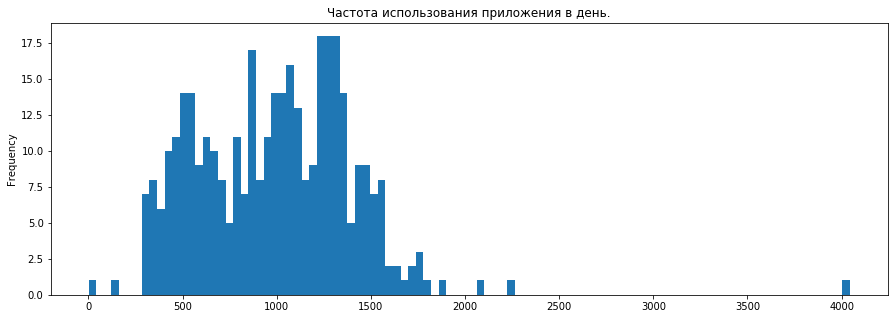

In [56]:
sessions_count['start_ts'].plot.hist(bins=100, figsize=(15,5), title='Частота использования приложения в день.');

Найдем среднее количество сессий в день для каждого пользователя.

In [57]:
sessions_mean = sessions.groupby(['uid', 'start_ts_day']).agg({'start_ts': 'count'}).mean()
sessions_mean

start_ts    1.087414
dtype: float64

ℹ️Большинство пользователей заходят в приложение только 1 раз в день. Можно подумать над мероприятиями по увеличению количество сессий, например над отправкой стимулирующих уведомлений.

<a id='session_length'></a>

----
### Сколько длится одна сессия?

In [58]:
sessions_length = visits_cohorts.copy()

In [59]:
sessions_length['start_ts_day'] = sessions['start_ts'].astype('datetime64[D]')

Рассчитаем длительность каждой сессий пользователя (в мин.).

In [60]:
sessions_length['length'] = (sessions_length['end_ts'] - sessions_length['start_ts'])/np.timedelta64(1, 'm')
sessions_length.head(3)

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week,start_ts_day,length
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch,2017-12-20 17:20:00,2017,12,2017-12-20,2017-12-18,2017-12-20,18.0
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop,2018-02-19 16:53:00,2018,2,2018-02-19,2018-02-19,2018-02-19,28.0
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch,2017-07-01 01:54:00,2017,7,2017-07-01,2017-06-26,2017-07-01,0.0


In [61]:
sessions_length.describe()

,uid,source_id,cohort_year,cohort_month,length
count,3.594000e+05,359400.000000,359400.000000,359400.000000,359400.000000
mean,9.202557e+18,3.750515,2017.343289,6.968166,10.717095
std,5.298433e+18,1.917116,0.474808,3.608847,16.618796
min,1.186350e+13,1.000000,2017.000000,1.000000,-46.000000
25%,4.613407e+18,3.000000,2017.000000,4.000000,2.000000
50%,9.227413e+18,4.000000,2017.000000,7.000000,5.000000
75%,1.372824e+19,5.000000,2018.000000,10.000000,14.000000
max,1.844668e+19,10.000000,2018.000000,12.000000,711.000000


Видим, что в таблице появились строки с отрицательной длительностью. Выберем эти значения из таблицы.

In [62]:
sessions_length[sessions_length['length'] < 0]

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week,start_ts_day,length
4181,2018-03-25 03:50:00,2018-03-25 03:18:00,13092152539246794986,3,desktop,2017-11-12 16:49:00,2017,11,2017-11-12,2017-11-06,2018-03-25,-32.0
177972,2018-03-25 03:55:00,2018-03-25 03:09:00,4621202742905035453,9,desktop,2018-03-19 18:40:00,2018,3,2018-03-19,2018-03-19,2018-03-25,-46.0


Обе записи от 2018-03-25. Посмотрим на остальных записи за эту дату.

In [63]:
sessions_length[sessions_length['start_ts_day'] == '2018-03-25'].head()

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week,start_ts_day,length
101,2018-03-25 10:24:00,2018-03-25 10:25:00,14642587066952531848,9,touch,2018-03-25 10:24:00,2018,3,2018-03-25,2018-03-19,2018-03-25,1.0
501,2018-03-25 10:35:00,2018-03-25 10:47:00,12127512885990086174,3,desktop,2018-03-25 10:35:00,2018,3,2018-03-25,2018-03-19,2018-03-25,12.0
725,2018-03-25 18:00:00,2018-03-25 18:11:00,16196330327785269213,9,desktop,2018-03-25 18:00:00,2018,3,2018-03-25,2018-03-19,2018-03-25,11.0
786,2018-03-25 18:38:00,2018-03-25 18:39:00,2047284828644749314,2,desktop,2018-03-25 18:38:00,2018,3,2018-03-25,2018-03-19,2018-03-25,1.0
1096,2018-03-25 15:50:00,2018-03-25 16:06:00,5194872953829644266,4,desktop,2018-03-25 15:50:00,2018,3,2018-03-25,2018-03-19,2018-03-25,16.0


В целом 2018-03-25 записи имеют обычный формат. Такие записи могли появиться в логах из-за системного сбоя. Можно написать баг-репорт.

При анализе исключим сессии с нулевой и отрицательной длительностью.

In [64]:
sessions_length[sessions_length['length'] < 0].shape[0]/sessions_length.shape[0]*100

0.0005564830272676682

Видим, что в результате удаления записей с отрицательной длительность количество записей сократится незначительно.

In [65]:
sessions_length = sessions_length.loc[sessions_length['length'] > 0]

Найдем среднюю длительность сессий в день для каждого пользователя.

In [66]:
#sessions_length = sessions_length.groupby(['uid', 'start_ts_day']).agg({'length': 'sum'})

In [67]:
sessions_length = sessions_length.groupby(by='uid').agg({'length': 'mean'})
sessions_length.head()

,length
uid,
11863502262781,6.0
49537067089222,2.0
297729379853735,1.0
313578113262317,11.0
325320750514679,5.0


Построим гистограмму, которая покажет какая длинна сессии обычна для пользователя.

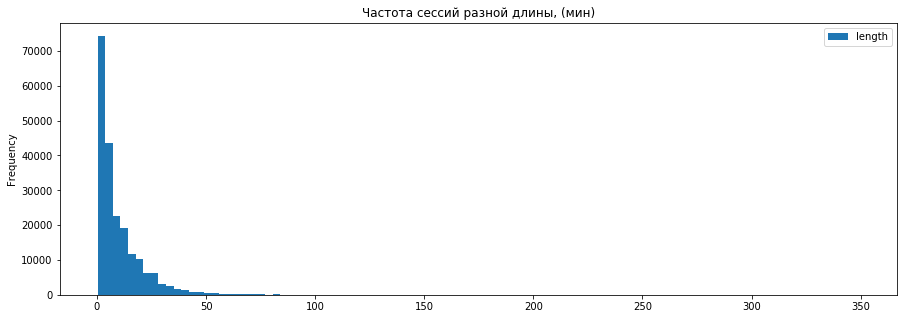

In [68]:
sessions_length.plot.hist(bins=100, figsize=(15,5), title='Частота сессий разной длины, (мин)');

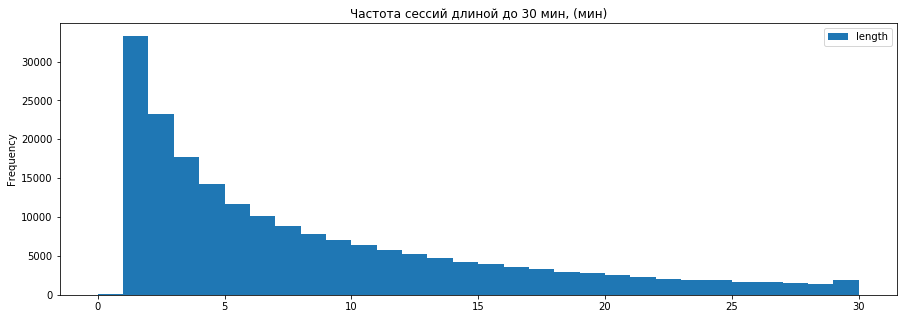

In [69]:
sessions_length.plot.hist(bins=30, figsize=(15,5), title='Частота сессий длиной до 30 мин, (мин)', range=(0, 30));


ℹ️ Самое большое количество сессий длительностью 1 минута.

<a id='retention_rate'></a>

----
### Как часто люди возвращаются?

Добавим в таблицу `visits` колонку `lifetime` - месяц жизненного цикла клиента

In [70]:
visits_cohorts['lifetime'] = ((visits_cohorts['start_ts'] - visits_cohorts['first_visit'])/np.timedelta64(1, 'M'))\
.round().astype('int')
visits_cohorts.head(3)

,start_ts,end_ts,uid,source_id,device,first_visit,cohort_year,cohort_month,cohort_day,cohort_week,lifetime
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch,2017-12-20 17:20:00,2017,12,2017-12-20,2017-12-18,0
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop,2018-02-19 16:53:00,2018,2,2018-02-19,2018-02-19,0
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch,2017-07-01 01:54:00,2017,7,2017-07-01,2017-06-26,0


Найдем количество уникальных пользователей в каждой когорте (год+месяц) на каждом этапе жизненного цикла.

In [71]:
lifetime = visits_cohorts.groupby(['cohort_year', 'cohort_month', 'lifetime']).agg({'uid': 'nunique'})
lifetime.head()

uid
cohort_year cohort_month lifetime       
2017        6            0         13259
                         1           986
                         2           710
                         3           813
                         4           921

Найдем количество уникальных пользователей на 0-м этапе жизни каждой когорты.

In [72]:
initial_cohort = visits_cohorts.groupby(['cohort_year', 'cohort_month']).agg({'uid': 'nunique'})
initial_cohort.columns = ['initial_uid']
initial_cohort.head(10)

initial_uid
cohort_year cohort_month             
2017        6                   13259
            7                   13140
            8                   10181
            9                   16704
            10                  25977
            11                  27248
            12                  25268
2018        1                   22624
            2                   22197
            3                   20589

Объединим сведения о количестве уникальных пользователей на начальном этапе и количество активных пользователей на каждом последующем этапе жизни когорты.

Посчитаем `retention_rate` на каждом этапе жижни когорт.

In [73]:
retention = lifetime.join(initial_cohort, on=['cohort_year', 'cohort_month'])

In [74]:
retention['retention_rate'] = retention['uid']/retention['initial_uid']

Построим сводную таблицу по `retention_rate`.

In [75]:
retention_pivot = retention.pivot_table(index=['cohort_year', 'cohort_month'], 
                      columns='lifetime', 
                      values='retention_rate', 
                      aggfunc='sum').round(3)
retention_pivot.fillna('')

lifetime                   0      1      2      3      4      5      6   \
cohort_year cohort_month                                                  
2017        6             1.0  0.074  0.054  0.061  0.069  0.066  0.064   
            7             1.0  0.057  0.052  0.054  0.057  0.049  0.045   
            8             1.0  0.069  0.062  0.059  0.051  0.042  0.042   
            9             1.0  0.077  0.066  0.049   0.04   0.04  0.033   
            10            1.0  0.074  0.053  0.038  0.037  0.031  0.021   
            11            1.0  0.070  0.046  0.039  0.032  0.024  0.019   
            12            1.0  0.051  0.041  0.029  0.022  0.016  0.003   
2018        1             1.0  0.054  0.036  0.026  0.017  0.002          
            2             1.0  0.048  0.027  0.018  0.002                 
            3             1.0  0.042  0.025  0.004                        
            4             1.0  0.040  0.004                               
            5             1.0  0.007                                      

lifetime                     7      8      9      10     11     12  
cohort_year cohort_month                                            
2017        6             0.056  0.056   0.05  0.041   0.04  0.013  
            7             0.049  0.037  0.029  0.024  0.005         
            8             0.034  0.029  0.023  0.003                
            9             0.026   0.02  0.003                       
            10            0.018  0.003                              
            11            0.003                                     
            12                                                      
2018        1                                                       
            2                                                       
            3                                                       
            4                                                       
            5

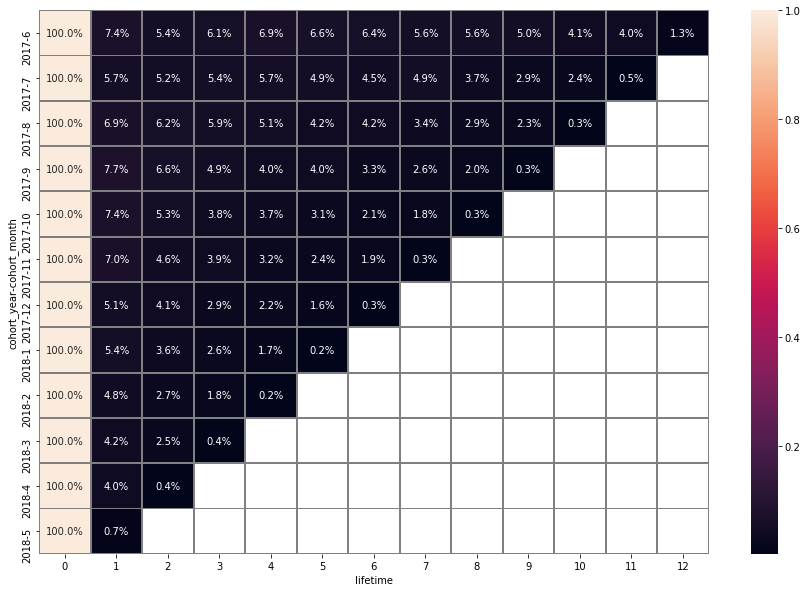

In [76]:
plt.figure(figsize = (15, 10))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

ℹ️ У сайта низкий reteintion rate. В первый месяц возвращается до 7.7% пользователей. 

У когорты 2017-9 самый высокий retention rate (7,7%) в первый месяц, однако к 9 месяцу он снизился почти до 0.

Самой удачной можно назвать когорту, привлеченную 2017-6, - retention rate в первый месяц был 7.4, по всем месяцам у нее остается самый высокий retention rate и спустя год 1.3% продолжают использовать сайт.

Самая неудачная когорта - последняя. Даже в первый месяц retention rate составил всего 0.7%, ниже, чем у когорты 2017-6 спустя год.

<a id='sales'></a>
## Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

<a id='start_ordering'></a>

----
### Когда люди начинают покупать?

Определим в каком месяце жизненного цикла после первого визита на сайт клиенты начинают покупать.

- Для каждого `uid` найдем дату его первого визита и дату первого заказа.

In [77]:
start_ordering = first_visit.merge(first_order, on='uid', how='left')
start_ordering.head()

,uid,first_visit,first_order
0,11863502262781,2018-03-01 17:27:00,NaT
1,49537067089222,2018-02-06 15:55:00,NaT
2,297729379853735,2017-06-07 18:47:00,NaT
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
4,325320750514679,2017-09-30 14:29:00,NaT


- Отберем `uid`, по которым были сделаны заказы и рассчитаем для них lifitime - когда был сделан первый заказ, относительно даты первого визита.

In [78]:
start_ordering = start_ordering[start_ordering['first_order'].notna()]

In [79]:
start_ordering['lifetime'] = ((start_ordering['first_order'] - start_ordering['first_visit'])/np.timedelta64(1, 'M')).round().astype('int')
start_ordering.head()

,uid,first_visit,first_order,lifetime
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,4
22,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
35,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0
36,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0
38,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


- Добавим столбцы с годом и месяцем когорты (по дате первого визита).

In [80]:
start_ordering['cohort_year'] = start_ordering['first_visit'].dt.year
start_ordering['cohort_month'] = start_ordering['first_visit'].dt.month
start_ordering.head()

,uid,first_visit,first_order,lifetime,cohort_year,cohort_month
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,4,2017,9
22,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,2017,6
35,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0,2017,10
36,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0,2018,1
38,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0,2017,11


- В сводной таблице выведем количество уникальных uid, которые начали покупки в определенный период жизненного цикла.

In [81]:
start_ordering_pivot = start_ordering.pivot_table(index=['cohort_year', 'cohort_month'], 
                                  columns='lifetime', 
                                  values='uid', 
                                  aggfunc='nunique')
start_ordering_pivot.fillna('')

lifetime                      0      1    2    3    4   5   6   7   8   9   \
cohort_year cohort_month                                                     
2017        6             2032.0  150.0   79   98  121  85  84  62  65  60   
            7             1753.0   93.0  107   86   87  80  68  63  52  30   
            8             1229.0  106.0   84   76   62  36  45  30  26  20   
            9             2310.0  214.0  152   86   64  81  70  39  39   3   
            10            3794.0  287.0  184  114  107  84  50  53   5       
            11            3449.0  305.0  152  120  105  65  58   8           
            12            3487.0  222.0  144   95   56  53  17               
2018        1             2697.0  198.0  110   57   51   6                   
            2             2896.0  153.0   68   58   11                       
            3             2659.0  121.0   49    9                            
            4             1796.0   86.0    8                                 
            5             2304.0   12.0                                      

lifetime                  10  11  12  
cohort_year cohort_month              
2017        6             29  45  13  
            7             28  11      
            8              7          
            9                         
            10                        
            11                        
            12                        
2018        1                         
            2                         
            3                         
            4                         
            5

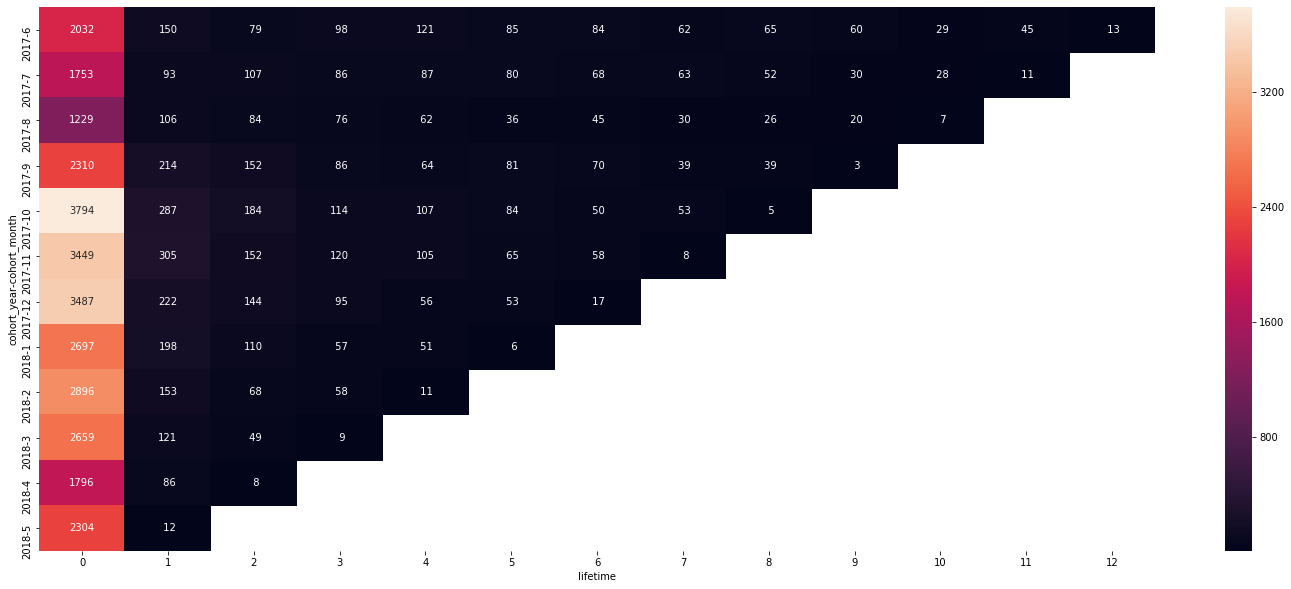

In [82]:
plt.figure(figsize=(25,10))
sns.heatmap(start_ordering_pivot, annot=True, fmt='3.0f');

ℹ️ Во всех когортах покупки начинают делать в первый месяц визита на сайт. Активнее всего покупали в первый месяц в когорте 2017-10.

<a id='purchases'></a>

----
### Сколько раз покупают за период?
Найдем количество покупкок для каждой когорты (по дате первого визита) в каждом lifetime.

In [83]:
first_visit.head(3)

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00


- Объединим таблицы `order_cohorts` и `first_visit` по `uid` и узнаем на какой месяц жизненного цикла приходится каждая покупка.

In [84]:
purchases = order_cohorts[['uid', 'buy_ts', 'revenue']].merge(first_visit, on='uid', how='left')

In [85]:
purchases['cohort_year'] = purchases['first_visit'].dt.year
purchases['cohort_month'] = purchases['first_visit'].dt.month

In [86]:
purchases.head()

,uid,buy_ts,revenue,first_visit,cohort_year,cohort_month
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01 00:09:00,2017,6
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01 00:14:00,2017,6
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01 00:25:00,2017,6
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01 00:14:00,2017,6
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01 07:31:00,2017,6


- Добавим в таблицу `purchases` поле `lifetime`.

In [87]:
purchases['lifetime'] = ((purchases['buy_ts'] - purchases['first_visit'])/np.timedelta64(1, 'M')).round().astype('int')
purchases.head()

,uid,buy_ts,revenue,first_visit,cohort_year,cohort_month,lifetime
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01 00:09:00,2017,6,0
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01 00:14:00,2017,6,0
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01 00:25:00,2017,6,0
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01 00:14:00,2017,6,0
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01 07:31:00,2017,6,0


- Построим сводную таблицу, содержащую количество заказов в каждой когорте по периодам жизненного цикла.

In [88]:
purchases_pivot = purchases.pivot_table(index=['cohort_year', 'cohort_month'], 
                                  columns='lifetime', 
                                  values='buy_ts', 
                                  aggfunc='count')
purchases_pivot.fillna('')

lifetime                      0      1    2    3    4    5    6    7    8   \
cohort_year cohort_month                                                     
2017        6             2334.0  358.0  267  404  514  365  548  345  356   
            7             1977.0  176.0  219  175  180  182  140  165  144   
            8             1390.0  201.0  197  176  160  103  124  123   85   
            9             2616.0  411.0  311  259  160  196  181  101   97   
            10            4320.0  543.0  375  242  266  194  126  148   19   
            11            4095.0  600.0  403  314  253  158  141   19        
            12            4011.0  430.0  293  223  134  120   25             
2018        1             3026.0  388.0  236  111   95    8                  
            2             3238.0  352.0  143  114   19                       
            3             3078.0  279.0  155   33                            
            4             1982.0  278.0   25                                 
            5             2452.0   25.0                                      

lifetime                   9    10   11  12  
cohort_year cohort_month                     
2017        6             348  226  237  95  
            7              90   75   22      
            8              70    9           
            9              14                
            10                               
            11                               
            12                               
2018        1                                
            2                                
            3                                
            4                                
            5

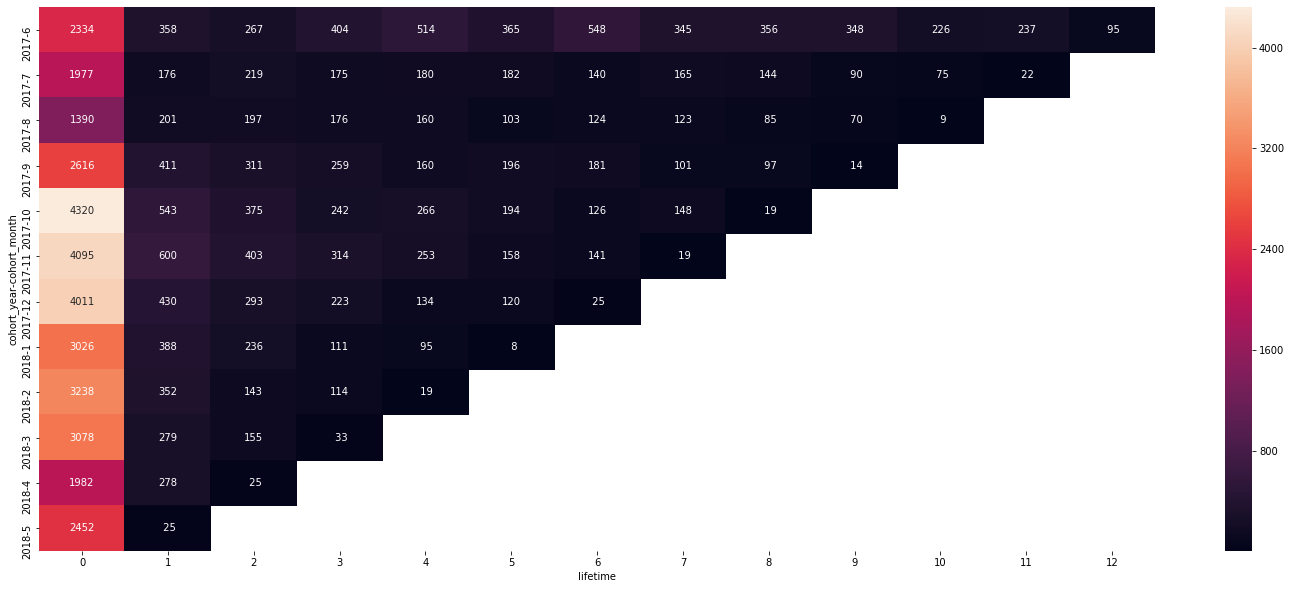

In [89]:
plt.figure(figsize=(25,10))
sns.heatmap(purchases_pivot, annot=True, fmt='3.0f');

ℹ️ На тепловой карте видно, что самая активная когорта 2017-6, они активно начали покупать сразу после первого посещения сайта, пиковая активность у них пришлась на 6 месяц знакомства с сайтом (это декабрь, возможно следствие каких-то сезонных/праздничных предложений). Ближе к 12 месяцам покупательская активность этой когорты пошла на спад и находится ниже 0-го месяца.

Последние привлеченные когорты делают маленькое количество покупок в 0-й месяц и дальше активность еще снижается.

<a id='avg_check'></a>

----
### Какой средний чек?

Чтобы определить средний чек:
1. найдем сумму покупок в каждой когорте по каждому периоду жизненного цикла.
2. найдем количество покупок в каждой когорте по каждому периоду жизненного цикла.
3. разделим сумму на количество
4. сформируем сводную таблицу и выведем тепловую карту

In [90]:
avg_check = purchases.groupby(['cohort_year', 'cohort_month', 'lifetime']).agg({'revenue': 'sum', 'buy_ts': 'count'})
avg_check.columns = ['sum', 'count']
avg_check['avg_check'] = avg_check['sum']/avg_check['count']
avg_check = avg_check.reset_index()
avg_check.head()

,cohort_year,cohort_month,lifetime,sum,count,avg_check
0,2017,6,0,9452.06,2334,4.049726
1,2017,6,1,2361.64,358,6.596760
2,2017,6,2,1445.11,267,5.412397
3,2017,6,3,2930.03,404,7.252550
4,2017,6,4,4590.81,514,8.931537


Определим средний чек в каждый из периодов жизненного цикла. В 3 и 11 месяцах заметен скачок суммы среднего чека, 

Построим сводную таблицу распределения среднего чека по когортам и жизненному циклу.

Выведем тепловую карту.

In [91]:
avg_check_pivot = avg_check.pivot_table(index=['cohort_year', 'cohort_month'], 
                           columns='lifetime', 
                           values='avg_check', 
                           aggfunc='sum')
avg_check_pivot.fillna('')

lifetime                        0         1        2        3        4   \
cohort_year cohort_month                                                  
2017        6             4.049726  6.596760   5.4124  7.25255  8.93154   
            7             5.028295  5.052216   5.4421  5.37131  4.64783   
            8             4.606223  4.706219  5.01858  5.69614  4.34581   
            9             4.897886  7.522214  6.92273  38.7866  11.9554   
            10            4.307998  5.917643  4.64779  3.90674   4.6782   
            11            4.186615  3.570950  3.84047  3.89073  4.02589   
            12            4.180843  4.232000  14.5504  22.5954  11.8194   
2018        1             3.625496  4.536830  4.20686  3.28505  4.22242   
            2             3.618950  4.911847  5.14776  6.46702     7.41   
            3             3.891212  3.864624  3.83019   3.6697            
            4             4.048643  5.847878   9.2972                     
            5             4.185587  4.338800                              

lifetime                       5        6        7        8        9   \
cohort_year cohort_month                                                
2017        6             6.73389  6.92359  5.80974   7.4866  9.95394   
            7             4.33324  4.28693  5.32491  4.80292  5.83933   
            8             5.06223  4.68516  9.37431  9.72894  4.48943   
            9             9.62393  4.87597  4.76168   3.7766      3.6   
            10            4.60253  3.73262  4.63196  2.75684            
            11            4.52291  4.11184  3.03263                     
            12            13.4817   2.6036                              
2018        1             7.14875                                       
            2                                                           
            3                                                           
            4                                                           
            5                                                           

lifetime                       10       11     12  
cohort_year cohort_month                           
2017        6              10.296  8.55684  5.326  
            7              4.8416  7.53909         
            8             3.34778                  
            9                                      
            10                                     
            11                                     
            12                                     
2018        1                                      
            2                                      
            3                                      
            4                                      
            5

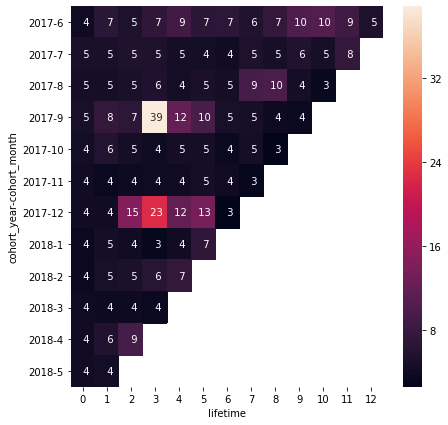

In [92]:
plt.figure(figsize=(7, 7))
sns.heatmap(avg_check_pivot, annot=True, fmt='3.0f');

In [93]:
avg_check_pivot.mean(axis=0)

lifetime
0      4.218956
1      5.091498
2      6.210588
3     10.092126
4      6.892941
5      6.938643
6      4.459959
7      5.489205
8      5.710380
9      5.970675
10     6.161798
11     8.047963
12     5.326000
dtype: float64

Найдем средний чек по за весь период.

In [94]:
(avg_check['sum'].sum()/avg_check['count'].sum()).round(2)

5.0

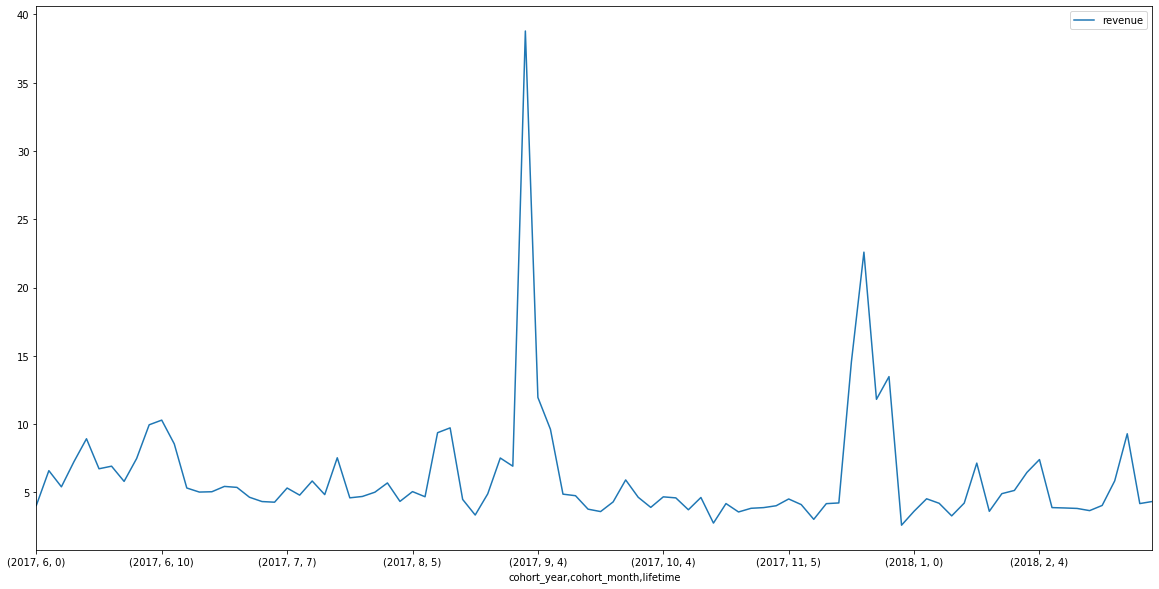

In [95]:
order_sum = purchases.groupby(['cohort_year', 'cohort_month', 'lifetime']).agg({'revenue': 'mean'})
order_sum.plot(figsize=(20, 10));

В когорте 2017-9 на 3 месяце lifetime наблюдается сильное увеличение средней суммы заказа.

ℹ️ Средний чек равен 5. Видно, что в когорте 2017-9 на 3 месяце lifetime наблюдается скачок суммы заказов. Вероятная причина какой-то очень дорогой заказ.

<a id='ltv'></a>

----
### Сколько денег приносят? (LTV)

Найдем LTV - сумму, которую в среднем приносит один клиент со всех своих покупок.

- Сгруппируем таблицу с заказами по когорте и этапу жизненного цикла (от даты первой покупки), вычислим сумму покупок и количество всех пользователей.
- Разделим сумму покпок на количество пользователей.

**Пример расчета LTV**

----

In [96]:
order_cohorts['lifetime'] = ((order_cohorts['buy_ts'] - order_cohorts['first_order'])/\
                             np.timedelta64(1, 'M')).round().astype('int')
order_cohorts.head()

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month,lifetime
0,2017-06-01 00:10:00,10329302124590727494,17.00,2017-06-01 00:10:00,2017,6,0
1,2017-06-01 00:25:00,11627257723692907447,0.55,2017-06-01 00:25:00,2017,6,0
2,2017-06-01 00:27:00,17903680561304213844,0.37,2017-06-01 00:27:00,2017,6,0
3,2017-06-01 00:29:00,16109239769442553005,0.55,2017-06-01 00:29:00,2017,6,0
4,2017-06-01 07:58:00,14200605875248379450,0.37,2017-06-01 07:58:00,2017,6,0


In [97]:
order_cohorts['first_order_m'] = order_cohorts['first_order'].dt.strftime('%Y-%m')
order_cohorts.head()

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month,lifetime,first_order_m
0,2017-06-01 00:10:00,10329302124590727494,17.00,2017-06-01 00:10:00,2017,6,0,2017-06
1,2017-06-01 00:25:00,11627257723692907447,0.55,2017-06-01 00:25:00,2017,6,0,2017-06
2,2017-06-01 00:27:00,17903680561304213844,0.37,2017-06-01 00:27:00,2017,6,0,2017-06
3,2017-06-01 00:29:00,16109239769442553005,0.55,2017-06-01 00:29:00,2017,6,0,2017-06
4,2017-06-01 07:58:00,14200605875248379450,0.37,2017-06-01 07:58:00,2017,6,0,2017-06


In [98]:
from IPython.display import display

In [99]:
test = order_cohorts.pivot_table(index=['first_order_m', 'lifetime'], 
                          values=['uid', 'revenue'],
                          aggfunc={'uid':'count',
                                   'revenue':"sum"}).reset_index()

In [100]:
test.head()

,first_order_m,lifetime,revenue,uid
0,2017-06,0,9620.09,2355
1,2017-06,1,783.90,147
2,2017-06,2,771.15,152
3,2017-06,3,1736.89,236
4,2017-06,4,2213.74,278


In [101]:
test['per_bu'] = test['revenue'] / test['uid']

In [102]:
final = test.pivot_table(index='first_order_m',
                 columns='lifetime',
                 values='per_bu',
                 aggfunc='sum').pipe(display)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order_m,,,,,,,,,,,,,
2017-06,4.084964,5.332653,5.073355,7.359703,7.963094,7.095245,6.564493,5.651421,6.920711,7.339425,10.605727,7.141935,5.183333
2017-07,5.293269,6.757391,10.101770,6.632667,4.918750,3.473284,3.238816,5.038500,6.766471,9.978148,4.755455,8.999231,NaN
2017-08,4.669590,7.490714,5.981122,8.095909,6.865758,6.426333,5.922361,6.932759,7.873462,5.971471,NaN,NaN,NaN
2017-09,5.015535,12.862908,15.526503,61.491554,19.574375,16.760179,8.865158,14.786441,6.883636,15.148889,NaN,NaN,NaN
2017-10,4.405853,7.333504,5.366538,4.887829,5.818000,4.484468,3.877500,5.051915,1.945405,NaN,NaN,NaN,NaN
2017-11,4.315476,5.030232,4.933409,5.716167,4.835039,3.985625,4.254675,5.478500,NaN,NaN,NaN,NaN,NaN
2017-12,4.088528,4.764504,18.880607,26.122983,16.639383,14.936633,3.519375,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3.677192,5.009289,7.107181,4.740933,2.965424,2.514286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,3.695992,4.781802,3.277590,4.105263,3.656667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

In [103]:
order_cohorts.tail(3)

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month,lifetime,first_order_m
50412,2018-05-31 23:54:00,1786462140797698849,0.30,2018-05-31 23:54:00,2018,5,0,2018-05
50413,2018-05-31 23:56:00,3993697860786194247,3.67,2018-05-31 23:56:00,2018,5,0,2018-05
50414,2018-06-01 00:02:00,83872787173869366,3.42,2018-06-01 00:02:00,2018,6,0,2018-06


In [104]:
order_cohorts['lifetime'] = ((order_cohorts['buy_ts'] - order_cohorts['first_order'])/np.timedelta64(1, 'M'))\
.round().astype('int')
order_cohorts.head(3)

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month,lifetime,first_order_m
0,2017-06-01 00:10:00,10329302124590727494,17.00,2017-06-01 00:10:00,2017,6,0,2017-06
1,2017-06-01 00:25:00,11627257723692907447,0.55,2017-06-01 00:25:00,2017,6,0,2017-06
2,2017-06-01 00:27:00,17903680561304213844,0.37,2017-06-01 00:27:00,2017,6,0,2017-06


In [105]:
ltv = order_cohorts.groupby(['cohort_year', 'cohort_month', 'lifetime']).agg({'revenue': 'sum', 'uid': 'count'})
ltv.columns = ['sum', 'n_buyer']
ltv['ltv'] = ltv['sum']/ltv['n_buyer']
ltv = ltv.reset_index()
ltv.head(5)

,cohort_year,cohort_month,lifetime,sum,n_buyer,ltv
0,2017,6,0,9620.09,2355,4.084964
1,2017,6,1,783.90,147,5.332653
2,2017,6,2,771.15,152,5.073355
3,2017,6,3,1736.89,236,7.359703
4,2017,6,4,2213.74,278,7.963094


- Выведем сводную таблицу значение LTV по когорам и жизненному циклу.

- LTV по этапам жизненного цикла рассчитаем нарастающим итогом.

In [106]:
ltv_pivot = ltv.pivot_table(index=['cohort_year', 'cohort_month'], columns='lifetime', values='ltv', aggfunc='sum')
ltv_pivot = ltv_pivot
ltv_pivot.fillna('')

lifetime                        0        1        2        3        4   \
cohort_year cohort_month                                                 
2017        6             4.084964  5.33265  5.07336   7.3597  7.96309   
            7             5.293269  6.75739  10.1018  6.63267  4.91875   
            8             4.669590  7.49071  5.98112  8.09591  6.86576   
            9             5.015535  12.8629  15.5265  61.4916  19.5744   
            10            4.405853   7.3335  5.36654  4.88783    5.818   
            11            4.315476  5.03023  4.93341  5.71617  4.83504   
            12            4.088528   4.7645  18.8806   26.123  16.6394   
2018        1             3.677192  5.00929  7.10718  4.74093  2.96542   
            2             3.695992   4.7818  3.27759  4.10526  3.65667   
            3             4.142281  5.78092  4.81063  21.8512            
            4             4.243975  5.74994  15.3462                     
            5             4.300093     2.74                              
            6             3.420000                                       

lifetime                       5        6        7        8        9   \
cohort_year cohort_month                                                
2017        6             7.09525  6.56449  5.65142  6.92071  7.33943   
            7             3.47328  3.23882   5.0385  6.76647  9.97815   
            8             6.42633  5.92236  6.93276  7.87346  5.97147   
            9             16.7602  8.86516  14.7864  6.88364  15.1489   
            10            4.48447   3.8775  5.05191  1.94541            
            11            3.98563  4.25468   5.4785                     
            12            14.9366  3.51937                              
2018        1             2.51429                                       
            2                                                           
            3                                                           
            4                                                           
            5                                                           
            6                                                           

lifetime                       10       11       12  
cohort_year cohort_month                             
2017        6             10.6057  7.14194  5.18333  
            7             4.75545  8.99923           
            8                                        
            9                                        
            10                                       
            11                                       
            12                                       
2018        1                                        
            2                                        
            3                                        
            4                                        
            5                                        
            6

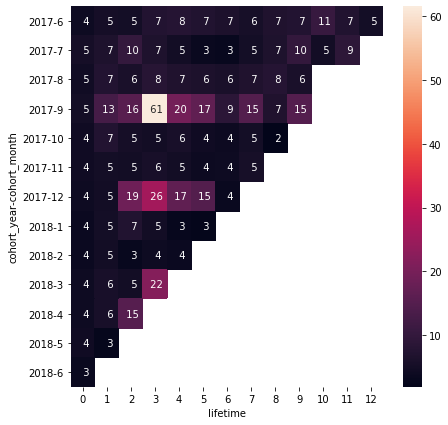

In [107]:
plt.figure(figsize=(7, 7))
sns.heatmap(ltv_pivot, annot=True, fmt='3.0f');

- LTV за 6 мес.

In [108]:
m6_ltv = ltv_pivot.mean()[5].round()
m6_ltv

7.0

ℹ️ Лучший показатель LTV у когорты 2017-06. На значение LTV в когорте 2017-09 и 2017-12 сильно повлиял рост среднего чека из-за крупного заказа клиента. 
LTV за 6 месяцев составил 52 руб. Такую сумму можно израсходовать на привлечение покупателя для того, чтобы рекламные расходы окупились за 6 месяцев.

<a id='marketing'></a>
## Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

<a id='month_costs'></a>

----
### Сколько денег потратили? Всего / на каждый источник / по времени

- Построим сводную таблицу затрат по дате (год+месяц) и рекламному источнику.

In [109]:
costs_pivot = costs.groupby(['cohort_year', 'cohort_month', 'source_id']).agg({'costs': 'sum'}).reset_index()
costs_pivot = costs_pivot.pivot_table(index=['cohort_year', 'cohort_month'], columns='source_id', values='costs', aggfunc='sum')

- Выведем суммарные расходы по каждому периоду.

In [110]:
month_costs = costs_pivot.sum(axis=1)
month_costs

cohort_year  cohort_month
2017         6               18015.00
             7               18240.59
             8               14790.54
             9               24368.91
             10              36322.88
             11              37907.88
             12              38315.35
2018         1               33518.52
             2               32723.03
             3               30415.27
             4               22289.38
             5               22224.27
dtype: float64

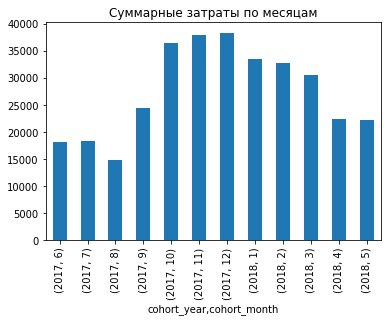

In [111]:
month_costs.plot.bar(y='sum', title='Суммарные затраты по месяцам');

In [112]:
# Рассчитаем коэффициент корреляции между затратами на рекламу и LTV за 1 месяц.
ltv_corr = ltv_pivot.reset_index().loc[:, 1]
month_costs.name = 'cost_corr'
cost_corr = month_costs.reset_index().loc[:, 'cost_corr']
cost_corr.corr(ltv_corr)

-0.20577554688970892

ℹ️ Самые высокие затраты на рекламу были в октябре-декабре 2017 года. Затраты на привлечение первой когорты 2017-6 и 2018-4 почти одинковы. При этом заметна небольшая обратная коррелация между затратами на привлечение и LTV в первый месяц.

- Выведем расходы по каждому периоду в разбивке по рекламным источникам.

In [113]:
costs_pivot

source_id                      1        2         3        4        5   \
cohort_year cohort_month                                                 
2017        6             1125.61  2427.38   7731.65  3514.80  2616.12   
            7             1072.88  2333.11   7674.37  3529.73  2998.14   
            8              951.81  1811.05   6143.54  3217.36  2185.28   
            9             1502.01  2985.66   9963.55  5192.26  3849.14   
            10            2315.75  4845.00  15737.24  6420.84  5767.40   
            11            2445.16  5247.68  17025.34  5388.82  6325.34   
            12            2341.20  4897.80  16219.52  7680.47  5872.52   
2018        1             2186.18  4157.74  14808.78  5832.79  5371.52   
            2             2204.48  4474.34  14228.56  5711.96  5071.31   
            3             1893.09  3943.14  13080.85  5961.87  4529.62   
            4             1327.49  2993.70   9296.81  4408.49  3501.15   
            5             1467.61  2689.44   9411.42  4214.21  3669.56   

source_id                     9       10  
cohort_year cohort_month                  
2017        6             285.22  314.22  
            7             302.54  329.82  
            8             248.93  232.57  
            9             415.62  460.67  
            10            609.41  627.24  
            11            683.18  792.36  
            12            657.98  645.86  
2018        1             547.16  614.35  
            2             551.50  480.88  
            3             480.29  526.41  
            4             373.49  388.25  
            5             362.17  409.86

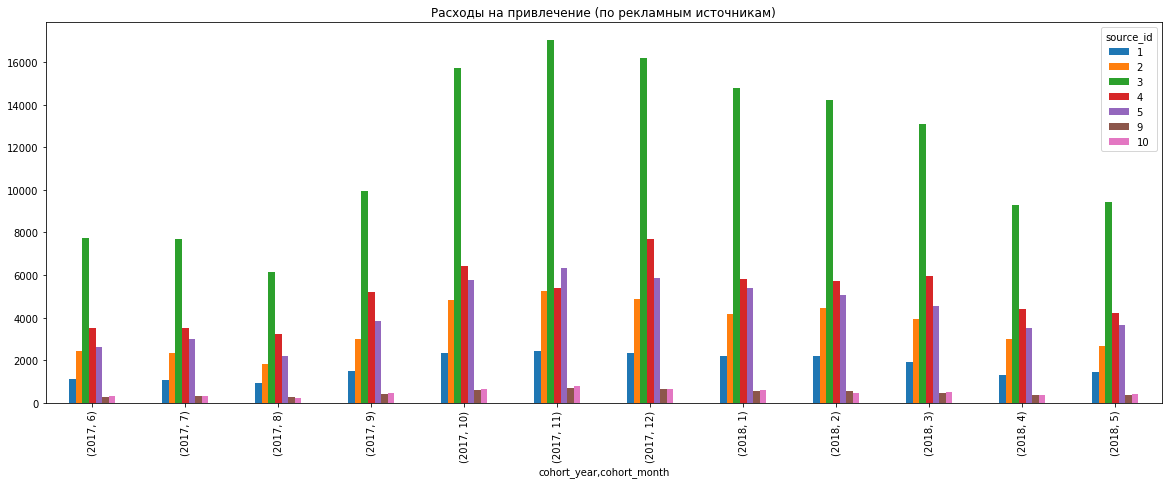

In [114]:
costs_pivot.plot.bar(figsize=(20,7), title='Расходы на привлечение (по рекламным источникам)');

In [115]:
# Рассчитаем коэффициент корреляции между затратами на рекламу по источникам и LTV за 1 месяц.
ltv_corr = ltv_pivot.reset_index().loc[:, 1]
costs_corr = costs_pivot.reset_index(drop=True).loc[:, [1,2,3,4,5,9,10]]
costs_corr.corrwith(ltv_corr)

source_id
1    -0.238882
2    -0.224525
3    -0.235678
4    -0.070685
5    -0.210304
9    -0.182503
10   -0.161611
dtype: float64

Суммы, потраченные на привлечение пользователей (по каждому источнику)

In [116]:
costs_pivot.sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
dtype: float64

Общая сумма расходов на привлечение пользователей за весь период.

In [117]:
costs['costs'].sum()

329131.62

ℹ️ Ежемесячные пропорции распределения затрат между источниками стабильны из месяца в месяц. Наибольшая сумма затрат приходится на рекламный источник 3, на 2-м месте источник 4, на 3-м источник 5.

В целом по всем источникам есть небольшая отрицательная корреляция между LTV первого месяца и затратами на различные источники. Коррелция с затратами на источник 1 наиболее выраженная.

<a id='users_per_source'></a>

----
### Сколько стоило привлечение одного покупателя из каждого источника?

1. Найти общую сумму затрат на привлечение покупателей в этот период по этому рекламному источнику.
2. Найти количество покупателей, привлеченных в этот период из этого рекламного источника.
3. Разделить сумму затрат на количество пользователей.

- Предположим, что источником заказа будет последний источник визита покупателя перед датой покупки. 
Из таблицы заказов получим дату заказа и uid покупателя. Определим ближайший к заказу визит и получим его источник - он и будет для нас являться источником заказа.

In [118]:
visits = visits.sort_values(by='start_ts').reset_index(drop=True)

In [119]:
order_cohorts['source_id'] = order_cohorts.apply(\
lambda x: visits[(visits['uid'] == x['uid']) & (visits['start_ts'] <= x['buy_ts'])]\
.iloc[-1]['source_id']\
, axis=1)

In [120]:
order_cohorts.tail()

,buy_ts,uid,revenue,first_order,cohort_year,cohort_month,lifetime,first_order_m,source_id
50410,2018-05-31 23:50:00,12296626599487328624,4.64,2018-05-31 23:50:00,2018,5,0,2018-05,4
50411,2018-05-31 23:50:00,11369640365507475976,5.80,2018-05-31 23:50:00,2018,5,0,2018-05,10
50412,2018-05-31 23:54:00,1786462140797698849,0.30,2018-05-31 23:54:00,2018,5,0,2018-05,3
50413,2018-05-31 23:56:00,3993697860786194247,3.67,2018-05-31 23:56:00,2018,5,0,2018-05,4
50414,2018-06-01 00:02:00,83872787173869366,3.42,2018-06-01 00:02:00,2018,6,0,2018-06,4


- Зная источник каждого заказа, посчитаем количество покупателей, для которых стимулом для покупки стал определенный источник.

In [121]:
buyers_count_pivot = order_cohorts.pivot_table(index=['cohort_year', 'cohort_month'], 
                                                 columns='source_id', 
                                                 values='uid', 
                                                 aggfunc='nunique')
buyers_count_pivot

source_id                    1      2       3       4       5    7      9   \
cohort_year cohort_month                                                     
2017        6             313.0  321.0   654.0   460.0   450.0  NaN   78.0   
            7             302.0  285.0   492.0   527.0   468.0  NaN   66.0   
            8             199.0  179.0   339.0   368.0   370.0  1.0   76.0   
            9             401.0  356.0   710.0   623.0   679.0  NaN   94.0   
            10            603.0  551.0  1108.0  1219.0  1066.0  NaN  152.0   
            11            665.0  573.0  1109.0  1227.0   776.0  NaN  159.0   
            12            654.0  552.0  1169.0  1402.0   817.0  NaN  132.0   
2018        1             441.0  364.0   914.0  1042.0   700.0  NaN   88.0   
            2             459.0  395.0   971.0  1098.0   755.0  NaN   78.0   
            3             460.0  422.0   872.0  1034.0   657.0  NaN  167.0   
            4             302.0  270.0   512.0   672.0   485.0  NaN   31.0   
            5             362.0  460.0   737.0   748.0   584.0  NaN   55.0   
            6               NaN    NaN     NaN     1.0     NaN  NaN    NaN   

source_id                    10  
cohort_year cohort_month         
2017        6              96.0  
            7              53.0  
            8              43.0  
            9              87.0  
            10            202.0  
            11            124.0  
            12             89.0  
2018        1              93.0  
            2             133.0  
            3             180.0  
            4             113.0  
            5             121.0  
            6               NaN

- Разделим количество затрат `costs_pivot` на количество привлеченных покупателей `buyers_count_pivot`.

In [136]:
costs_per_buyer = costs_pivot/buyers_count_pivot

In [137]:
costs_per_buyer = costs_per_buyer.fillna(0)
costs_per_buyer

source_id                       1          2          3         4         5   \
cohort_year cohort_month                                                       
2017        6             3.596198   7.561931  11.822095  7.640870  5.813600   
            7             3.552583   8.186351  15.598313  6.697780  6.406282   
            8             4.782965  10.117598  18.122537  8.742826  5.906162   
            9             3.745661   8.386685  14.033169  8.334286  5.668837   
            10            3.840381   8.793103  14.203285  5.267301  5.410319   
            11            3.676932   9.158255  15.351975  4.391866  8.151211   
            12            3.579817   8.872826  13.874696  5.478224  7.187907   
2018        1             4.957324  11.422363  16.202166  5.597687  7.673600   
            2             4.802789  11.327443  14.653512  5.202149  6.716967   
            3             4.115413   9.343934  15.000975  5.765832  6.894399   
            4             4.395662  11.087778  18.157832  6.560253  7.218866   
            5             4.054171   5.846609  12.769905  5.633971  6.283493   
            6             0.000000   0.000000   0.000000  0.000000  0.000000   

source_id                  7          9         10  
cohort_year cohort_month                            
2017        6             0.0   3.656667  3.273125  
            7             0.0   4.583939  6.223019  
            8             0.0   3.275395  5.408605  
            9             0.0   4.421489  5.295057  
            10            0.0   4.009276  3.105149  
            11            0.0   4.296730  6.390000  
            12            0.0   4.984697  7.256854  
2018        1             0.0   6.217727  6.605914  
            2             0.0   7.070513  3.615639  
            3             0.0   2.875988  2.924500  
            4             0.0  12.048065  3.435841  
            5             0.0   6.584909  3.387273  
            6             0.0   0.000000  0.000000

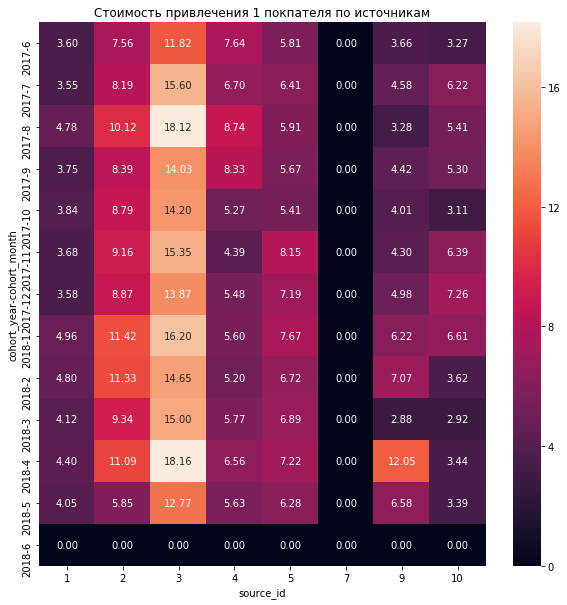

In [124]:
plt.figure(figsize=(10, 10))
plt.title('Стоимость привлечения 1 покпателя по источникам')
sns.heatmap(costs_per_buyer, annot=True, fmt='.2f');

ℹ️ Ежемесячные пропорции распределения стоимости привлечения покупателя по источникам стабильны из месяца в месяц. Наиболее высокая стоимость привлечения у источника 3, на втором месте источник 2, на третьем источник 5.

<a id='roi'></a>

----
### На сколько окупились расходы? (ROI)

Рассчитаем ROI = Валовая прибыль/Затраты

In [125]:
gp = purchases.groupby(['cohort_year', 'cohort_month', 'lifetime']).agg({'revenue': 'sum'})

In [126]:
gp_pivot = gp.pivot_table(index=['cohort_year', 'cohort_month'], columns='lifetime', values='revenue', aggfunc='sum')
gp_pivot = gp_pivot.cumsum(axis=1)
gp_pivot.fillna('')

lifetime                        0         1        2        3        4   \
cohort_year cohort_month                                                  
2017        6              9452.06  11813.70  13258.8  16188.8  20779.6   
            7              9940.94  10830.13  12021.9  12961.9  13798.5   
            8              6402.65   7348.60  8337.26  9339.78  10035.1   
            9             12812.87  15904.50  18057.5  28103.2  30016.1   
            10            18610.55  21823.83  23566.7  24512.2  25756.6   
            11            17144.19  19286.76  20834.5  22056.2  23074.7   
            12            16769.36  18589.12  22852.4  27891.2    29475   
2018        1             10970.75  12731.04  13723.9  14088.5  14489.6   
            2             11718.16  13447.13  14183.3  14920.5  15061.3   
            3             11977.15  13055.38  13649.1  13770.2            
            4              8024.41   9650.12  9882.55                     
            5             10263.06  10371.53                              

lifetime                       5        6        7        8        9   \
cohort_year cohort_month                                                
2017        6             23237.5  27031.6    29036  31701.2  35165.2   
            7             14587.2  15187.4    16066  16757.6  17283.1   
            8             10556.5  11137.5  12290.5  13117.5  13431.7   
            9             31902.4  32784.9  33265.8  33632.2  33682.6   
            10            26649.5  27119.8  27805.3  27857.7            
            11            23789.3  24369.1  24426.7                     
            12            31092.8  31157.8                              
2018        1             14546.8                                       
            2                                                           
            3                                                           
            4                                                           
            5                                                           

lifetime                       10       11       12  
cohort_year cohort_month                             
2017        6             37492.1  39520.1  40026.1  
            7             17646.2  17812.1           
            8             13461.9                    
            9                                        
            10                                       
            11                                       
            12                                       
2018        1                                        
            2                                        
            3                                        
            4                                        
            5

In [127]:
roi = gp_pivot.div(month_costs, axis=0)

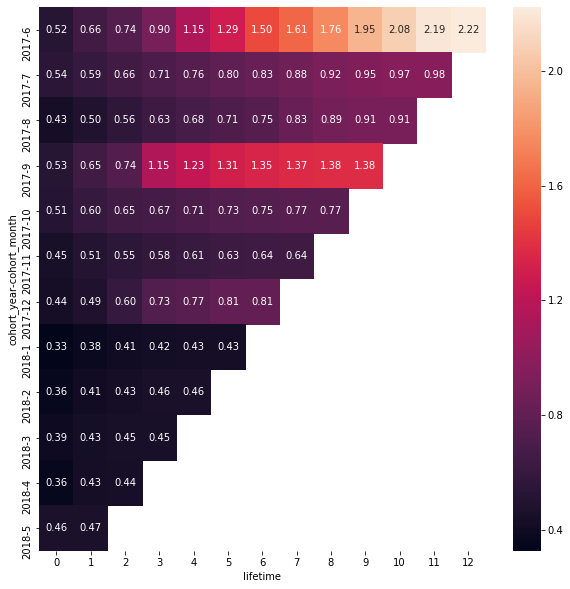

In [128]:
plt.figure(figsize=(10, 10))
sns.heatmap(roi, annot=True, fmt='.2f')

ℹ️ Выше всего ROI у когорты 2017-9, затраты на привлечения окупились в 3-м месяце, после крупного заказа.
Расходы на привлечение для когорты 2017-6 окупились в 4-м месяце. Остальные когорты еще не вышли на окупаемость - затраты на привлечение пока еще ниже, чем выручка от их заказов.

----

Найдем сумму расходов на привлечение 1 покупателя. Для этого разделим всю сумму расходов на количество уникальных покупателей за весь период.

In [129]:
buyer_count = len(orders['uid'].unique())
costs_per_buyer = costs['costs'].sum()/buyer_count
costs_per_buyer

9.011626098622786

Конверсия за период

In [130]:
visits_count = len(visits['uid'].unique())
conversion = buyer_count/visits_count*100
conversion

16.006994815246596

In [131]:
100/conversion

6.2472688442898985

<a id='summary'></a>
# Выводы и рекомендации

- LTV за 6 месяцев составил 52 руб. - такую сумму можно израсходовать на привлечение покупателя для того, чтобы рекламные расходы окупились.

- Расходы на привлечение в пересчете на 1 покупателя составили 9 руб.

- Конверсия за период составила 16%. Чтобы получить 1 покупателя необходимо привлечь не менее 7 посетителей на сайт.

- Наиболее высокая стоимость привлечения у источника 3, на втором месте источник 2, на третьем источник 5.

- Большинство пользователей заходят в приложение только 1 раз в день, в основном продолжительность сессии 1 минута. Можно подумать над дополнительным стимулированием использования приложения, например отправка уведомлений.

- Лучший показатель LTV у когорты 2017-06. На значение LTV в когорте 2017-09 и 2017-12 сильно повлиял рост среднего чек. 

- Наиболее успешной можно считать когорту 2017-6. У когорты стабильный retention rate, пользователи продолжают возвращаться спустя год. С течением времени LTV и средний чек в этой когорте возрастает. Расходы на привлечение окупились уже в 4 месяце.

- Самое большое количество покупок совершили пользователи когорты 2017-10, на 2-м месте когорта 2017-12, на 3-м месте 2017-11.

- В данных можно заметить большие заказы в когортах 2017-9 и 2017-12, который повлияли на рост общей выручки и среднего чека в этих когортах. Можно посмотреть что именно могло простимулировать крупную покупку.

- Наибольшая сумма затрат приходится на рекламный источник 3, на 2-м месте источник 2.

- Выше всего ROI у когорты 2017-9, затраты на привлечения окупились в 3-м месяце, после крупного заказа.Расходы на привлечение для когорты 2017-6 окупились в 4-м месяце. Остальные когорты еще не вышли на окупаемость - затраты на привлечение пока еще ниже, чем выручка от их заказов.

- Стоит более внимательно рассмотреть механизм привлечения и взаимодействия с когортой 2017-6, т.к. ее показатели в целом более оптимальные.